In [1]:
import sys
import localSettings as ls
print(ls.main_path)

/Users/cerati/Notebooks/PELEE/


In [2]:
main_path = ls.main_path
sys.path.append(main_path)

In [3]:
SHRCALIBFACTOR = 1.00

In [34]:
# USING BDT?
USEBDT = True

In [35]:
# Doing Run3?
ISRUN3 = True

In [36]:
import matplotlib.pyplot as plt

In [37]:
import plotter
import importlib
importlib.reload(plotter)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

In [38]:
fold = "nuselection"
tree = "NeutrinoSelectionFilter"

BNB = ""
EXT = ""
NU  = ""
NUE = ""
DRT = ""
NCPI0 = ""
CCPI0 = ""
CCNOPI = ""
CCCPI = ""
NCNOPI = ""
NCCPI = ""

if ISRUN3:
    BNB = 'data_bnb_mcc9.1_v08_00_00_25_reco2_G1_beam_good_reco2_1e19'
    EXT = 'data_extbnb_mcc9.1_v08_00_00_25_reco2_G_all_reco2'
    NU  = 'prodgenie_bnb_nu_uboone_overlay_mcc9.1_v08_00_00_26_filter_run3_reco2_G_reco2'
    NUE = 'prodgenie_bnb_intrinsice_nue_uboone_overlay_mcc9.1_v08_00_00_26_run3_reco2_reco2'
    DRT = 'prodgenie_bnb_dirt_overlay_mcc9.1_v08_00_00_26_run3_reco2_reco2'
    NCPI0  = 'prodgenie_nc_pi0_uboone_overlay_mcc9.1_v08_00_00_26_run3_G_reco2'
    CCPI0  = 'prodgenie_cc_pi0_uboone_overlay_v08_00_00_26_run3_G_reco2'
    CCNOPI = 'prodgenie_CCmuNoPi_overlay_mcc9_v08_00_00_33_all_run3_reco2_reco2'
    CCCPI  = 'prodgenie_filter_CCmuCPiNoPi0_overlay_mcc9_v08_00_00_33_run3_reco2_reco2'
    NCNOPI = 'prodgenie_ncnopi_overlay_mcc9_v08_00_00_33_new_run3_reco2_reco2'
    NCCPI  = 'prodgenie_NCcPiNoPi0_overlay_mcc9_v08_00_00_33_New_run3_reco2_reco2'
    
else:
    BNB = 'data_bnb_mcc9.1_v08_00_00_25_reco2_C1_beam_good_reco2_5e19'
    #EXT = 'data_extbnb_mcc9.1_v08_00_00_25_reco2_C_all_reco2'
    EXT = 'data_extbnb_mcc9.1_v08_00_00_25_reco2_C1_C2_D1_D2_E1_E2_all_reco2' #Run1 + Run2
    NU  = 'prodgenie_bnb_nu_uboone_overlay_mcc9.1_v08_00_00_26_filter_run1_reco2_reco2'
    NUE = 'prodgenie_bnb_intrinsice_nue_uboone_overlay_mcc9.1_v08_00_00_26_run1_reco2_reco2'
    DRT = 'prodgenie_bnb_dirt_overlay_mcc9.1_v08_00_00_26_run1_reco2_reco2'
    NCPI0  = 'prodgenie_nc_pi0_uboone_overlay-v08_00_00_26_run1_reco2_reco2'
    CCPI0  = 'prodgenie_cc_pi0_uboone_overlay_v08_00_00_26_run1_reco2'
    CCNOPI = 'prodgenie_CCmuNoPi_overlay_mcc9_v08_00_00_33_all_run1_reco2_reco2'
    CCCPI  = 'prodgenie_filter_CCmuCPiNoPi0_overlay_mcc9_v08_00_00_33_run1_reco2_reco2'
    NCNOPI = 'prodgenie_ncnopi_overlay_mcc9_v08_00_00_33_run1_reco2_reco2'
    NCCPI  = 'prodgenie_NCcPiNoPi0_overlay_mcc9_v08_00_00_33_run1_reco2_reco2'
        
mc = uproot.open(ls.ntuple_path+NU+".root")[fold][tree]
ncpi0 = uproot.open(ls.ntuple_path+NCPI0+".root")[fold][tree]
ccpi0 = uproot.open(ls.ntuple_path+CCPI0+".root")[fold][tree]
ccnopi = uproot.open(ls.ntuple_path+CCNOPI+".root")[fold][tree]
cccpi = uproot.open(ls.ntuple_path+CCCPI+".root")[fold][tree]
ncnopi = uproot.open(ls.ntuple_path+NCNOPI+".root")[fold][tree]
nccpi = uproot.open(ls.ntuple_path+NCCPI+".root")[fold][tree]
nue = uproot.open(ls.ntuple_path+NUE+".root")[fold][tree]
data = uproot.open(ls.ntuple_path+BNB+".root")[fold][tree]
ext = uproot.open(ls.ntuple_path+EXT+".root")[fold][tree]
dirt = uproot.open(ls.ntuple_path+DRT+".root")[fold][tree]
lee = uproot.open(ls.ntuple_path+NUE+".root")[fold][tree]

uproot_v = [lee,mc,ncpi0,ccpi0,ccnopi,cccpi,ncnopi,nccpi,nue,ext,data,dirt]

variables = [
    "shr_dedx_Y", "shr_bkt_pdg", "p", "pt", "selected", "nu_pdg", "shr_theta",
    "slpdg", "trk_score_v", "backtracked_pdg", # modified from shr_score_v
    "shr_pfp_id_v", "category", "shr_tkfit_dedx_Y",
    "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
    "shr_tkfit_gap10_dedx_U","shr_tkfit_gap10_dedx_V","shr_tkfit_gap10_dedx_Y",
    "shr_tkfit_2cm_dedx_U","shr_tkfit_2cm_dedx_V","shr_tkfit_2cm_dedx_Y",
    #"shr_energy_tot", 
    "trk_energy_tot", "shr_hits_tot", "ccnc", "trk_chipr",
    "trk_bkt_pdg", "hits_ratio", "n_tracks_contained", 
    "crtveto","crthitpe","_closestNuCosmicDist",
    "NeutrinoEnergy2",
    #"run","sub","evt",
    "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
    "nu_flashmatch_score","best_cosmic_flashmatch_score","best_obviouscosmic_flashmatch_score",
    #"trk_pfp_id",
    "shrmoliereavg","shrmoliererms",
    "shr_tkfit_npointsvalid","shr_tkfit_npoints", # fitted vs. all hits for shower
    "shrclusfrac0","shrclusfrac1","shrclusfrac2", # track-fitted hits / all hits
    "trkshrhitdist2", # "trkshrhitdist0","trkshrhitdist1", distance between track and shower in 2D
    "shrsubclusters0","shrsubclusters1","shrsubclusters2", # number of sub-clusters in shower
    "trk_llr_pid_score_v", # trk-PID score
    #"pi0_energy2_Y", # pi0 tagger variables
    "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
    "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
    "nproton", "nu_e", "n_showers_contained", "shr_distance", "trk_distance",
    "hits_y", "shr_pz", "shr_energy", "shr_dedx_U", "shr_dedx_V", "shr_phi", "trk_phi", "trk_theta",
    "shr_tkfit_dedx_U", "shr_tkfit_dedx_V", "run", "sub", "evt", "nproton", "trk_pid_chipr_v",
    "trk_len", "mc_pdg", "slnunhits", "slnhits", "shr_score", "trk_score", "trk_hits_tot",
    "true_e_visible", "matched_E", "shr_bkt_E", "trk_bkt_E", "trk_energy", "tksh_distance", "tksh_angle",
    "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
    "pi0_e", "shr_energy_tot_cali", "shr_dedx_Y_cali", "evnunhits", "nslice", "interaction",
    "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z","contained_fraction",
    "secondshower_Y_nhit","secondshower_Y_vtxdist","secondshower_Y_dot","secondshower_Y_dir","shrclusdir2",
    "isVtxInFiducial","truthFiducial","nproton",
    "true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z",
    "shr_start_x","shr_start_y","shr_start_z",
    "shr_tkfit_nhits_Y","shr_tkfit_nhits_U","shr_tkfit_nhits_V",
    "shr_tkfit_2cm_nhits_Y","shr_tkfit_2cm_nhits_U","shr_tkfit_2cm_nhits_V",
    "shr_tkfit_gap10_nhits_Y","shr_tkfit_gap10_nhits_U","shr_tkfit_gap10_nhits_V"
]
#make the list unique
variables = list(set(variables))
print(variables)

if not ISRUN3:
    variables.remove("_closestNuCosmicDist")
    variables.remove("crtveto")
    variables.remove("crthitpe")
    
WEIGHTS = ["weightSpline","weightTune","weightSplineTimesTune"]#, "weightsGenie", "weightsFlux", "weightsReint"]
WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
           "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
           "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue = nue.pandas.df(variables + WEIGHTS, flatten=False)
mc = mc.pandas.df(variables + WEIGHTS + MCFVARS, flatten=False)
ncpi0 = ncpi0.pandas.df(variables + WEIGHTS, flatten=False)
ccpi0 = ccpi0.pandas.df(variables + WEIGHTS, flatten=False)
ccnopi = ccnopi.pandas.df(variables + WEIGHTS, flatten=False)
cccpi = cccpi.pandas.df(variables + WEIGHTS, flatten=False)
ncnopi = ncnopi.pandas.df(variables + WEIGHTS, flatten=False)
nccpi = nccpi.pandas.df(variables + WEIGHTS, flatten=False)
data = data.pandas.df(variables, flatten=False)
ext = ext.pandas.df(variables, flatten=False)
dirt = dirt.pandas.df(variables + WEIGHTS, flatten=False)
lee = lee.pandas.df(variables + WEIGHTSLEE, flatten=False)

['best_cosmic_flashmatch_score', 'trk_bkt_pdg', 'shrclusfrac2', 'run', 'selected', 'true_nu_vtx_sce_x', 'n_tracks_contained', 'shr_tkfit_nhits_V', 'trk_score', 'sub', 'shr_tkfit_2cm_dedx_V', 'shr_tkfit_2cm_dedx_Y', 'shr_phi', 'shr_bkt_E', 'slclustfrac', 'shr_tkfit_2cm_nhits_V', 'true_e_visible', 'reco_nu_vtx_sce_y', 'best_obviouscosmic_flashmatch_score', 'shr_tkfit_dedx_V', 'pi0_e', 'crtveto', 'trk_llr_pid_score_v', 'shr_dedx_V', 'shr_tkfit_dedx_U', 'contained_fraction', 'shr_tkfit_npoints', 'trkshrhitdist2', 'trk_pid_chipr_v', 'n_showers_contained', 'matched_E', 'evnunhits', 'shr_dedx_Y_cali', 'interaction', 'shr_tkfit_2cm_nhits_Y', 'nu_e', 'shrmoliereavg', 'true_nu_vtx_sce_y', 'trk_energy_tot', 'trk_theta', 'shr_tkfit_2cm_nhits_U', 'shr_dedx_U', 'shrclusfrac0', 'shr_score', 'secondshower_Y_vtxdist', 'shr_tkfit_gap10_dedx_Y', 'nu_flashmatch_score', 'true_nu_vtx_sce_z', 'shrmoliererms', 'shr_tkfit_gap10_nhits_Y', 'trk_energy', 'npion', 'secondshower_Y_dot', 'shr_pfp_id_v', 'mc_pdg', 's

In [39]:
df_v = [lee,mc,ncpi0,ccpi0,ccnopi,cccpi,ncnopi,nccpi,nue,dirt]

for i,df in enumerate(df_v):
    
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.
    #df['weightSpline']  = df['weightSpline']  * df['weightTune']

In [40]:
# how to get the LLR-PID value for the "track candidate" (proton for nue selection, muon for numu)
# can be done for any variable
# code from Giuseppe!

df_v = [lee,mc,ncpi0,ccpi0,ccnopi,cccpi,ncnopi,nccpi,nue,ext,data,dirt]
#df_v = [lee,mc,nue,ext,data,dirt]

for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_llr_pid_v = up.array('trk_llr_pid_score_v')
    trk_id = up.array('trk_id')-1 # I think we need this -1 to get the right result
    trk_llr_pid_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    df['trkpid'] = trk_llr_pid_v_sel
    df['subcluster'] = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    df['trkfit'] = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
    df['anglediff_Y'] = np.abs(df['secondshower_Y_dir']-df['shrclusdir2'])
    #df['FMdiffOBV'] = df['nu_flashmatch_score']-df['best_obviouscosmic_flashmatch_score']
    #df['FMdiff'] = df['nu_flashmatch_score']-df['best_cosmic_flashmatch_score']

In [41]:
INTERCEPT = 0.0
SLOPE = 0.83

# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    df["reco_e_qe"] = 0.938*((df["shr_energy"]+INTERCEPT)/SLOPE)/(0.938 - ((df["shr_energy"]+INTERCEPT)/SLOPE)*(1-np.cos(df["shr_theta"])))
    df["reco_e_rqe"] = df["reco_e_qe"]/df["reco_e"]

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])
data["bnbdata"] = np.ones_like(data["shr_energy"])
ext["extdata"] = np.ones_like(ext["shr_energy"])

# test calibrating dedx on Y plane
#data["shr_tkfit_gap10_dedx_Y"] = data["shr_tkfit_gap10_dedx_Y"]*1.03
#ext["shr_tkfit_gap10_dedx_Y"] = ext["shr_tkfit_gap10_dedx_Y"]*1.03
#data["shr_tkfit_2cm_dedx_Y"] = data["shr_tkfit_2cm_dedx_Y"]*1.03
#ext["shr_tkfit_2cm_dedx_Y"] = ext["shr_tkfit_2cm_dedx_Y"]*1.03
#data["shr_tkfit_dedx_Y"] = data["shr_tkfit_dedx_Y"]*1.03
#ext["shr_tkfit_dedx_Y"] = ext["shr_tkfit_dedx_Y"]*1.03


In [42]:
for i,df in enumerate(df_v):
    df['dx'] = df['reco_nu_vtx_x']-df['true_nu_vtx_sce_x']
    df['dy'] = df['reco_nu_vtx_y']-df['true_nu_vtx_sce_y']
    df['dz'] = df['reco_nu_vtx_z']-df['true_nu_vtx_sce_z']
    df['dr'] = np.sqrt( df['dx']*df['dx'] + df['dy']*df['dy'] + df['dz']*df['dz'] )

for i,df in enumerate(df_v):
    df['dx_s'] = df['shr_start_x']-df['true_nu_vtx_sce_x']
    df['dy_s'] = df['shr_start_y']-df['true_nu_vtx_sce_y']
    df['dz_s'] = df['shr_start_z']-df['true_nu_vtx_sce_z']
    df['dr_s'] = np.sqrt( df['dx_s']*df['dx_s'] + df['dy_s']*df['dy_s'] + df['dz_s']*df['dz_s'] )

df_v = [lee,mc,ncpi0,ccpi0,ccnopi,cccpi,ncnopi,nccpi,nue,ext,data,dirt]
for i,df in enumerate(df_v):
    df['shr_tkfit_nhits_tot'] = (df['shr_tkfit_nhits_Y']+df['shr_tkfit_nhits_U']+df['shr_tkfit_nhits_V'])
    df['shr_tkfit_dedx_avg'] = (df['shr_tkfit_nhits_Y']*df['shr_tkfit_dedx_Y'] + df['shr_tkfit_nhits_U']*df['shr_tkfit_dedx_U'] + df['shr_tkfit_nhits_V']*df['shr_tkfit_dedx_V'])/df['shr_tkfit_nhits_tot']
    df['shr_tkfit_2cm_nhits_tot'] = (df['shr_tkfit_2cm_nhits_Y']+df['shr_tkfit_2cm_nhits_U']+df['shr_tkfit_2cm_nhits_V'])
    df['shr_tkfit_2cm_dedx_avg'] = (df['shr_tkfit_2cm_nhits_Y']*df['shr_tkfit_2cm_dedx_Y'] + df['shr_tkfit_2cm_nhits_U']*df['shr_tkfit_2cm_dedx_U'] + df['shr_tkfit_2cm_nhits_V']*df['shr_tkfit_2cm_dedx_V'])/df['shr_tkfit_2cm_nhits_tot']
    df['shr_tkfit_gap10_nhits_tot'] = (df['shr_tkfit_gap10_nhits_Y']+df['shr_tkfit_gap10_nhits_U']+df['shr_tkfit_gap10_nhits_V'])
    df['shr_tkfit_gap10_dedx_avg'] = (df['shr_tkfit_gap10_nhits_Y']*df['shr_tkfit_gap10_dedx_Y'] + df['shr_tkfit_gap10_nhits_U']*df['shr_tkfit_gap10_dedx_U'] + df['shr_tkfit_gap10_nhits_V']*df['shr_tkfit_gap10_dedx_V'])/df['shr_tkfit_gap10_nhits_tot']
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']

In [43]:
# avoid double-counting of events out of FV in the NC/CC pi0 samples
# not needed anymore since we improved matching with filtered samples
#ncpi0 = ncpi0.query('category != 5')
#ccpi0 = ccpi0.query('category != 5')
#ccnopi = ccnopi.query('category != 5')
#nccpi = nccpi.query('category != 5')
#ncnopi = ncnopi.query('category != 5')

## avoid recycling unbiased ext events (i.e. selecting a slice with little nu content from these samples)
ccnopi = ccnopi.query('(nslice==0 | (slnunhits/slnhits)>0.1)')
cccpi = cccpi.query('(nslice==0 | (slnunhits/slnhits)>0.1)')
ncnopi = ncnopi.query('(nslice==0 | (slnunhits/slnhits)>0.1)')
nccpi = nccpi.query('(nslice==0 | (slnunhits/slnhits)>0.1)')

# add back the cosmic category, for background only
df_v = [lee,mc,ncpi0,ccpi0,ccnopi,cccpi,ncnopi,nccpi,nue,ext,data,dirt]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4

In [44]:
lee["is_signal"] = lee["category"] == 11
data["is_signal"] = data["category"] == 11
nue["is_signal"] = nue["category"] == 11
mc["is_signal"] = mc["category"] == 11
dirt["is_signal"] = dirt["category"] == 11
ext["is_signal"] = ext["category"] == 11
ncpi0["is_signal"] = ncpi0["category"] == 11
ccpi0["is_signal"] = ccpi0["category"] == 11
ccnopi["is_signal"] = ccnopi["category"] == 11
cccpi["is_signal"] = cccpi["category"] == 11
ncnopi["is_signal"] = ncnopi["category"] == 11
nccpi["is_signal"] = nccpi["category"] == 11

lee.loc[lee['category'] == 1, 'category'] = 111
lee.loc[lee['category'] == 10, 'category'] = 111
lee.loc[lee['category'] == 11, 'category'] = 111

if (USEBDT == True):
    if (ISRUN3): train_ccpi0, ccpi0 = train_test_split(ccpi0, test_size=0.5, random_state=1990)

In [48]:
# variables to be trained on
TRAINVAR = ["shr_score","tksh_distance","tksh_angle",
            "shr_tkfit_dedx_max","trkfit","trkpid",
            "subcluster","shrmoliereavg",
            "trkshrhitdist2","hits_ratio",
            "secondshower_Y_nhit","secondshower_Y_vtxdist","secondshower_Y_dot","anglediff_Y",
            "CosmicIPAll3D","CosmicDirAll3D"]

In [49]:
LABELS = ['pi0','nonpi0']

if (USEBDT == True):
    for label, bkg_query in zip(LABELS, nue_booster.bkg_queries):
        with open(ls.pickle_path+'booster_%s_0304.pickle' % label, 'rb') as booster_file:
            booster = pickle.load(booster_file)
            mc[label+"_score"] = booster.predict(
                xgb.DMatrix(mc[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            nue[label+"_score"] = booster.predict(
                xgb.DMatrix(nue[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            ext[label+"_score"] = booster.predict(
                xgb.DMatrix(ext[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            data[label+"_score"] = booster.predict(
                xgb.DMatrix(data[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            dirt[label+"_score"] = booster.predict(
                xgb.DMatrix(dirt[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            lee[label+"_score"] = booster.predict(
                xgb.DMatrix(lee[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            ncpi0[label+"_score"] = booster.predict(
                xgb.DMatrix(ncpi0[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            ccpi0[label+"_score"] = booster.predict(
                xgb.DMatrix(ccpi0[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            ccnopi[label+"_score"] = booster.predict(
                xgb.DMatrix(ccnopi[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            cccpi[label+"_score"] = booster.predict(
                xgb.DMatrix(cccpi[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            ncnopi[label+"_score"] = booster.predict(
                xgb.DMatrix(ncnopi[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            nccpi[label+"_score"] = booster.predict(
                xgb.DMatrix(nccpi[TRAINVAR]),
                ntree_limit=booster.best_iteration)


/Users/cerati/miniconda3/envs/mypython3new/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [50]:
dfbdt_v = [lee,mc,ncpi0,ccpi0,ccnopi,cccpi,ncnopi,nccpi,nue,ext,data,dirt]

In [51]:
import plotter
import importlib
importlib.reload(plotter)

<module 'plotter' from '/Users/cerati/Notebooks/PELEE/plotter.py'>

In [52]:
samples = {
    "mc": mc,
    "nue": nue,
    "data": data,
    "ext": ext,
    "dirt": dirt,
    "ncpi0": ncpi0,
    "ccpi0": ccpi0,
    "ccnopi": ccnopi,
    "cccpi": cccpi,
    "ncnopi": ncnopi,
    "nccpi": nccpi,
    "lee": lee,
}

if ISRUN3:
    scaling = 101.0/0.763
else:
    scaling = 101.0/4.08
scaling = 1

SPLIT = 1.0
if (USEBDT == True):
    SPLIT = 2.

#0304
if ISRUN3:
    weights = {
        "mc": 5.70e-03 * scaling,
        "nue": 1.21e-04 * scaling,
        "ext": 2.11e-02 * scaling,
        "dirt": 2.35e-02 * scaling,
        "lee": 1.21e-04 * scaling,
        "ncpi0": 3.33e-03 * scaling,
        "ccpi0": 1.18e-03 * SPLIT * scaling,
        "ncnopi": 1.11e-03 * scaling,
        "nccpi": 5.51e-04 * scaling,
        "ccnopi": 1.71e-03 * scaling,
        "cccpi": 1.44e-03 * scaling,
    }
    pot = 0.763e19*scaling
else:
    weights = {
        "mc": 3.12e-02 * scaling,
        "nue": 7.73e-04 * scaling,
        "ext": 4.83e-02 * scaling, #C+D+E #C only: 1.40e-01
        "dirt": 1.26e-01 * scaling,
        "lee": 7.73e-04 * scaling,
        "ncpi0": 1.53e-02 * scaling,
        "ccpi0": 1.17e-02 * scaling,
        "ncnopi": 1.12e-02 * scaling,
        "nccpi": 4.56e-03 * scaling,
        "ccnopi": 8.81e-03 * scaling,
        "cccpi": 6.74e-03 * scaling,
    }
    pot = 4.08e19*scaling
    
my_plotter = plotter.Plotter(samples, weights, pot=pot)
print(weights)

{'mc': 0.0057, 'nue': 0.000121, 'ext': 0.0211, 'dirt': 0.0235, 'lee': 0.000121, 'ncpi0': 0.00333, 'ccpi0': 0.00236, 'ncnopi': 0.00111, 'nccpi': 0.000551, 'ccnopi': 0.00171, 'cccpi': 0.00144}


In [53]:
# nue preselection
PRESQ = 'nslice == 1'
PRESQ += ' and selected == 1'
PRESQ += ' and shr_energy_tot_cali > 0.07'
PRESQ += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'

In [54]:
# 1eNp preselection
NPPRESQ = PRESQ
NPPRESQ += ' and n_tracks_contained > 0'

In [55]:
# loose box cuts
NPLCUTQ = NPPRESQ
NPLCUTQ += ' and CosmicIPAll3D > 10.'
NPLCUTQ += ' and trkpid < 0.05'
NPLCUTQ += ' and hits_ratio > 0.5'
NPLCUTQ += ' and shrmoliereavg < 10'
NPLCUTQ += ' and subcluster > 4'
NPLCUTQ += ' and trkfit < 0.70'
NPLCUTQ += ' and n_showers_contained == 1'
NPLCUTQ += ' and tksh_distance < 6.0'
NPLCUTQ += ' and shr_tkfit_dedx_max > 0.0 and shr_tkfit_dedx_max < 4.5'
NPLCUTQ += ' and secondshower_Y_nhit < 50'
NPLCUTQ += ' and tksh_angle > -0.9'

In [56]:
# tight box cuts
NPTCUTQ = NPLCUTQ
NPTCUTQ += ' and CosmicIPAll3D > 30.'
NPTCUTQ += ' and CosmicDirAll3D > -0.98 and CosmicDirAll3D < 0.98'
NPTCUTQ += ' and trkpid < 0.02'
NPTCUTQ += ' and hits_ratio > 0.65'
NPTCUTQ += ' and shr_score < 0.25'
NPTCUTQ += ' and shrmoliereavg > 2 and shrmoliereavg < 10'
NPTCUTQ += ' and subcluster > 7'
NPTCUTQ += ' and trkfit < 0.70'
NPTCUTQ += ' and n_showers_contained == 1'
NPTCUTQ += ' and tksh_distance < 4.0'
NPTCUTQ += ' and trkshrhitdist2 < 1.5'
NPTCUTQ += ' and (shr_tkfit_nhits_tot > 1 and shr_tkfit_dedx_max > 1.0 and shr_tkfit_dedx_max < 3.8)'
NPTCUTQ += ' and (secondshower_Y_nhit<=8 or secondshower_Y_dot<=0.8 or anglediff_Y<=40 or secondshower_Y_vtxdist>=100)'
NPTCUTQ += ' and secondshower_Y_nhit < 30'
NPTCUTQ += ' and tksh_angle > -0.9 and tksh_angle < 0.70'

In [57]:
# BDT cuts
NPBDTCQ = NPLCUTQ
# 0304, pi0 and nonpi0
NPBDTCQ += ' and pi0_score > 0.69 and nonpi0_score > 0.70'

In [85]:
cutlist = []
cutlist.append({"cut": "nslice == 1", "name": "nslice"})
cutlist.append({"cut": "contained_fraction >= 0.9", "name": "contained"})
cutlist.append({"cut": "n_showers_contained > 0", "name": "n_showers"})
cutlist.append({"cut": "shr_energy_tot_cali > 0.07", "name": "shr_energy"})
cutlist.append({"cut": "( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)", "name": "optical filter"})
cutlist.append({"cut": "n_tracks_contained > 0", "name": "n_tracks"})
cutlist.append({"cut": 'CosmicIPAll3D > 30.', "name": "CosmicIPAll3D"})
cutlist.append({"cut": 'CosmicDirAll3D > -0.98 and CosmicDirAll3D < 0.98', "name": "CosmicDirAll3D"})
cutlist.append({"cut": 'trkpid < 0.02', "name": "trkpid"})
cutlist.append({"cut": 'hits_ratio > 0.65', "name": "hits_ratio"})
cutlist.append({"cut": 'shr_score < 0.25', "name": "shr_score"})
cutlist.append({"cut": 'shrmoliereavg > 2 and shrmoliereavg < 10', "name": "shrmoliereavg"})
cutlist.append({"cut": 'subcluster > 7', "name": "subcluster"})
cutlist.append({"cut": 'trkfit < 0.70', "name": "trkfit"})
cutlist.append({"cut": 'n_showers_contained == 1', "name": "n_showers1"})
cutlist.append({"cut": 'tksh_distance < 4.0', "name": "tksh_distance"})
cutlist.append({"cut": 'trkshrhitdist2 < 1.5', "name": "trkshrhitdist2"})
cutlist.append({"cut": '(shr_tkfit_nhits_tot > 1 and shr_tkfit_dedx_max > 1.0 and shr_tkfit_dedx_max < 3.8)', "name": "dedx_max"})
cutlist.append({"cut": '(secondshower_Y_nhit<=8 or secondshower_Y_dot<=0.8 or anglediff_Y<=40 or secondshower_Y_vtxdist>=100)', "name": "secondshower"})
cutlist.append({"cut": '(secondshower_Y_nhit<30)', "name": "secondshower_Y_nhit"})
cutlist.append({"cut": 'tksh_angle > -0.9 and tksh_angle < 0.70', "name": "tksh_angle"})

In [ ]:
# OLD loose box cuts
OLCUTQ = PRESQ
OLCUTQ += ' and n_tracks_contained > 0'
OLCUTQ += ' and CosmicIP > 20.'
OLCUTQ += ' and trkpid < 0.1'
OLCUTQ += ' and hits_ratio > 0.5'
OLCUTQ += ' and shr_score < 0.30'
OLCUTQ += ' and n_showers_contained == 1'
OLCUTQ += ' and tksh_distance < 6.0'
OLCUTQ += ' and shr_tkfit_2cm_dedx_Y < 4.0'
OLCUTQ += ' and tksh_angle > -0.9'
# OLD tight box cuts
OTCUTQ = OLCUTQ
OTCUTQ += ' and tksh_distance < 3.5'
OTCUTQ += ' and (shr_tkfit_2cm_dedx_Y > 0 and shr_tkfit_2cm_dedx_Y < 4.0 and shr_tkfit_2cm_dedx_U < 4.0 and shr_tkfit_2cm_dedx_V < 4.0)'
OTCUTQ += ' and (shr_tkfit_gap10_dedx_Y > 0 and shr_tkfit_gap10_dedx_Y < 4.5 and shr_tkfit_gap10_dedx_U < 4.5 and shr_tkfit_gap10_dedx_V < 4.5)'
OTCUTQ += ' and tksh_angle > -0.9 and tksh_angle < 0.75'
OTCUTQ += ' and shrmoliereavg > 2 and shrmoliereavg < 9'
OTCUTQ += ' and trkpid < -0.02'
OTCUTQ += ' and n_showers_contained == 1'
OTCUTQ += ' and shr_score < 0.275'
OTCUTQ += ' and hits_ratio > 0.60'
OTCUTQ += ' and (secondshower_Y_nhit<=8 or secondshower_Y_dot<=0.8 or anglediff_Y<=40 or secondshower_Y_vtxdist>=100)'
OTCUTQ += ' and (trkfit < 0.45 or subcluster > 6)'

In [ ]:
cutlist = []
cutlist.append({"cut": "nslice == 1", "name": "nslice"})
cutlist.append({"cut": "contained_fraction >= 0.9", "name": "contained"})
cutlist.append({"cut": "n_showers_contained > 0", "name": "n_showers"})
cutlist.append({"cut": "shr_energy_tot_cali > 0.07", "name": "shr_energy"})
cutlist.append({"cut": "n_tracks_contained > 0", "name": "n_tracks"})
cutlist.append({"cut": 'CosmicIP > 20.', "name": "CosmicIPAll3D"})
cutlist.append({"cut": 'trkpid < -0.02', "name": "trkpid"})
cutlist.append({"cut": 'hits_ratio > 0.60', "name": "hits_ratio"})
cutlist.append({"cut": 'shr_score < 0.275', "name": "shr_score"})
cutlist.append({"cut": 'shrmoliereavg > 2 and shrmoliereavg < 10', "name": "shrmoliereavg"})
cutlist.append({"cut": '(trkfit < 0.45 or subcluster > 6)', "name": "subcluster, trkfit"})
cutlist.append({"cut": 'n_showers_contained == 1', "name": "n_showers1"})
cutlist.append({"cut": 'tksh_distance < 3.5', "name": "tksh_distance"})
cutlist.append({"cut": '(shr_tkfit_2cm_dedx_Y > 0 and shr_tkfit_2cm_dedx_Y < 4.0 and shr_tkfit_2cm_dedx_U < 4.0 and shr_tkfit_2cm_dedx_V < 4.0)', "name": "2cm_dedx"})
cutlist.append({"cut": '(shr_tkfit_gap10_dedx_Y > 0 and shr_tkfit_gap10_dedx_Y < 4.5 and shr_tkfit_gap10_dedx_U < 4.5 and shr_tkfit_gap10_dedx_V < 4.5)', "name": "gap10_dedx"})
cutlist.append({"cut": '(secondshower_Y_nhit<=8 or secondshower_Y_dot<=0.8 or anglediff_Y<=40 or secondshower_Y_vtxdist>=100)', "name": "secondshower"})
cutlist.append({"cut": 'tksh_angle > -0.9 and tksh_angle < 0.70', "name": "tksh_angle"})

In [ ]:
# Define actual selection
QUERY = NPTCUTQ
# in case you do not want to look at the data
QUERY += ' and bnbdata==0'
# in case you want to apply the CRT veto
#if ISRUN3: QUERY += ' and (crtveto!=1) and (_closestNuCosmicDist > 20.)'

In [ ]:
miniboone_bins = [
    0, 0.200, 0.300, 0.375, 0.475, 0.550, 0.675, 0.800, 0.950, 1.100, 1.300,
    1.500, 3.000
]

#QUERY += " and nu_pdg == 12"
#QUERY += " & pi0truth_elec_etot<15 & npi0 == 0 & ccnc == 0"
#QUERY += " & muon_e>0.3 & npi0 == 0 & ccnc == 0"
#QUERY = "(muon_e<0.3 | pi0truth_elec_etot>=15) & npi0 == 0 & npion == 0 & ccnc == 0 & nu_pdg == 14 & category == 2"
#QUERY += " & ~((muon_e<0.3 | pi0truth_elec_etot>=15) & npi0 == 0 & npion == 0 & ccnc == 0 & nu_pdg == 14 & category != 5)"

#VARIABLE, BINS, RANGE, XTIT = 'reco_e',13,(0.2,1.5),r"Reconstructed Energy [GeV]"
VARIABLE, BINS, RANGE, XTIT = 'reco_e',14,(0.1,1.5),r"Reconstructed Energy [GeV]"
#VARIABLE, BINS, RANGE, XTIT = 'pi0_mass_Y',20,(0,500),"pi0 mass Y"

#VARIABLE, BINS, RANGE, XTIT = 'muon_e',20,(0.,1.),r"Muon Energy [GeV]"
#VARIABLE, BINS, RANGE, XTIT = 'pi0truth_elec_etot',20,(0.,60),r"Michel Energy [GeV]"

#VARIABLE, BINS, RANGE, XTIT = 'dr',10,(0.,20),r"DeltaR [cm]"
#VARIABLE, BINS, RANGE, XTIT = 'shr_tkfit_2cm_nhits_Y',10,(0.,10),r"shr_tkfit_2cm_nhits Y"
#VARIABLE, BINS, RANGE, XTIT = 'shr_tkfit_2cm_nhits_U',10,(0.,10),r"shr_tkfit_2cm_nhits U"
#VARIABLE, BINS, RANGE, XTIT = 'shr_tkfit_2cm_nhits_V',10,(0.,10),r"shr_tkfit_2cm_nhits V"
#VARIABLE, BINS, RANGE, XTIT = 'shr_tkfit_2cm_dedx_Y',10,(0.,10),r"shr_tkfit_2cm_dedx Y"

fig, ax1, ax2, stack, labls, ext = my_plotter.plot_variable(
    VARIABLE,   
    query=QUERY,
    kind="event_category",
    #kind="interaction",
    #kind="sample",
    #kind='particle_pdg',
    draw_sys=False,
    stacksort=3,
    title=XTIT,
    #bins=asymm_bins,
    bins=BINS,
    range=RANGE,
)#[0:3]

print(stack[0])
print(labls)
print(ext)

nuel = -1
for i, l in enumerate(labls):
    #print(i,l)
    if 'nu_e' in l and 'Np' in l: 
        nuel = i
        break
#print('nue purity=',(stack[0][nuel]-stack[0][nuel-1])/stack[0][nuel])

print("Profile likelihood: %.2f sigma @ 1.01e21 POT" % my_plotter.significance_likelihood)
print("s/sqrt(b): %.2f sigma @ 1.01e21 POT" % my_plotter.significance)

#ax1.set_ylim(0,40)
#ax1.set_yscale("log")
#ax1.set_ylim(0,200)
ax1.set_ylim(0,ax1.get_ylim()[1]*1.5)
#ax2.set_ylim(0.5,1.5)
#fig.savefig(ls.plots_path+"/0109/run3/presel/"+VARIABLE+"_"+date_time+".pdf")

In [59]:
def Eff(df,var,query,acceptance,bin_edges,absval=False):
    #print acceptance
    bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
    bins = []
    bin_eff = []
    bin_err = []
    for i in range(len(bin_centers)):
        binmin = bin_edges[i]
        binmax = bin_edges[i+1]
        bincut = '%s > %f and %s < %f'%(var,binmin,var,binmax)
        if (absval == True):
            bincut = '(%s > %f and %s < %f) or (%s > -%f and %s < -%f)'%(var,binmin,var,binmax,var,binmax,var,binmin)
        if (acceptance != ''): bincut += ' and %s'%acceptance
        #print bincut
        df_tmp =  df.query(bincut) # cut on bin range for desired var.
        df_sub = df_tmp.query(query) # apply constrain 
        if (df_tmp.shape[0] == 0): continue
        eff = df_sub.shape[0] / float( df_tmp.shape[0] )
        err = np.sqrt( eff*(1-eff)/df_tmp.shape[0] )
        bin_eff.append( eff )
        bin_err.append( err )
        bins.append(bin_centers[i])
        #print 'eff = %.02f @ bin = %.02f'%(eff,bin_centers[i])
    return np.array(bins),np.array(bin_eff),np.array(bin_err)

In [60]:
def Pur(my_plotter,VARIABLE,QUERY,BINS,RANGE):
    fig, ax1, ax2, stack, labls, ext = my_plotter.plot_variable(
        VARIABLE,   
        query=QUERY,
        kind="event_category",
        draw_sys=False,
        stacksort=3,
        title="my_xaxis",
        bins=BINS,
        range=RANGE,
    )
    nuel = -1
    for i, l in enumerate(labls):
        if 'nu_e' in l and 'Np' in l: 
            nuel = i
            break
    plt.close(fig)
    return (stack[0][nuel]-stack[0][nuel-1])/(stack[0][nuel]+ext)

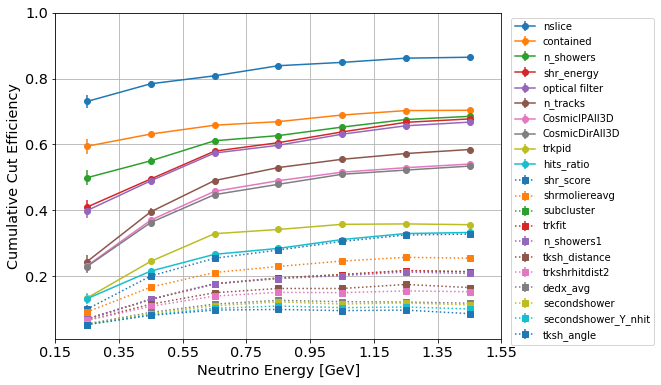

In [61]:
#fig = plt.figure(figsize=(8,6))
fig, ax = plt.subplots(figsize=(8,6))

bin_edges = np.linspace(0.15,1.55,8)

VAR = 'nu_e' #'_pi0_e'
ACCEPTANCE = 'isVtxInFiducial == 1 and truthFiducial == 1 and npi0==0 and npion==0 and nproton>0'
#ACCEPTANCE += ' and dr_s<1.0'

for c in range(0,len(cutlist)):
    if c==0: cut = cutlist[c]["cut"]
    else: cut = cut+" and "+cutlist[c]["cut"]
    fmt = 'o-'
    if c>9: fmt = 's:'
    centers,vals,errs = Eff(nue,VAR,cut,ACCEPTANCE,bin_edges)
    ax.errorbar(centers,vals,yerr=errs,fmt=fmt,label=cutlist[c]["name"])
ax.set_xlabel('Neutrino Energy [GeV]')
ax.set_ylabel('Cumulative Cut Efficiency')
ax.set_xticks(bin_edges)
ax.set_ylim(0.01,1.0)
ax.set_xlim(bin_edges[0],bin_edges[-1])
plt.legend(bbox_to_anchor=(1.01,1.), loc='upper left', ncol=1)
#plt.title("dr(shr vtx reco, vtx mc sce)<1.0")
plt.grid(True)
#plt.yscale('log')
plt.show()


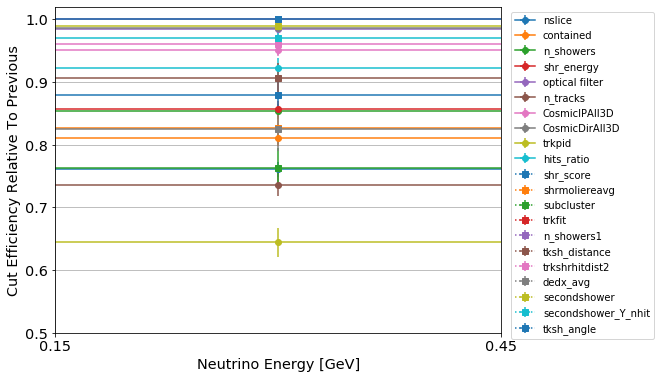

In [62]:
#fig = plt.figure(figsize=(8,6))
fig, ax = plt.subplots(figsize=(8,6))

#bin_edges = np.linspace(0.15,1.55,8)
bin_edges = np.linspace(0.15,0.45,2)

VAR = 'nu_e' #'_pi0_e'
ACCEPTANCE = 'isVtxInFiducial == 1 and truthFiducial == 1 and npi0==0 and npion==0 and nproton>0'
#ACCEPTANCE += ' and dr_s<1.0'

for c in range(0,len(cutlist)):
    if c==0: cut = cutlist[c]["cut"]
    else: cut = cut+" and "+cutlist[c]["cut"]
    fmt = 'o-'
    if c>9: fmt = 's:'
    if c>0: ACCEPTANCE = ACCEPTANCE+" and "+cutlist[c-1]["cut"]
    centers,vals,errs = Eff(nue,VAR,cut,ACCEPTANCE,bin_edges)
    ax.errorbar(centers,vals,yerr=errs,xerr=(bin_edges[1]-bin_edges[0])/2,fmt=fmt,label=cutlist[c]["name"])
ax.set_xlabel('Neutrino Energy [GeV]')
ax.set_ylabel('Cut Efficiency Relative To Previous')
ax.set_xticks(bin_edges)
ax.set_ylim(0.5,1.02)
ax.set_xlim(bin_edges[0],bin_edges[-1])
plt.legend(bbox_to_anchor=(1.01,1.), loc='upper left', ncol=1)
#plt.title("dr(shr vtx reco, vtx mc sce)<1.0")
plt.grid(True)
plt.show()


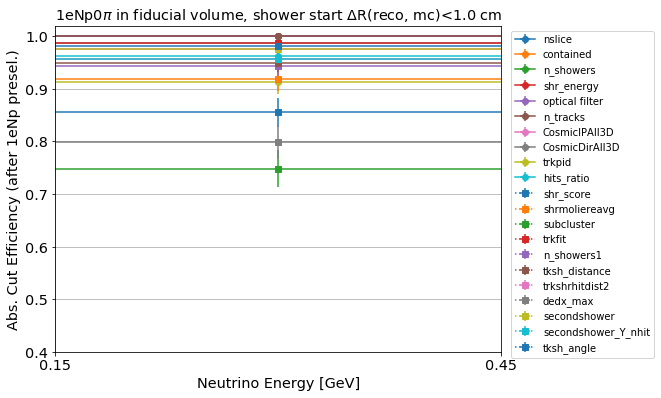

In [93]:
#fig = plt.figure(figsize=(8,6))
fig, ax = plt.subplots(figsize=(8,6))

#bin_edges = np.linspace(0.15,1.55,8)
bin_edges = np.linspace(0.15,0.45,2)

VAR = 'nu_e' #'_pi0_e'
ACCEPTANCE = 'isVtxInFiducial == 1 and truthFiducial == 1 and npi0==0 and npion==0 and nproton>0'
ACCEPTANCE += ' and '+NPPRESQ
#ACCEPTANCE += ' and dr_s<1.0'

for c in range(0,len(cutlist)):
    fmt = 'o-'
    if c>9: fmt = 's:'
    centers,vals,errs = Eff(nue,VAR,cutlist[c]["cut"],ACCEPTANCE,bin_edges)
    ax.errorbar(centers,vals,yerr=errs,xerr=(bin_edges[1]-bin_edges[0])/2,fmt=fmt,label=cutlist[c]["name"])
ax.set_xlabel('Neutrino Energy [GeV]')
ax.set_ylabel('Abs. Cut Efficiency (after 1eNp presel.)')
ax.set_xticks(bin_edges)
ax.set_ylim(0.4,1.02)
ax.set_xlim(bin_edges[0],bin_edges[-1])
plt.legend(bbox_to_anchor=(1.01,1.), loc='upper left', ncol=1)
plt.title(r"1eNp0$\pi$ in fiducial volume")
#plt.title(r"1eNp0$\pi$ in fiducial volume, shower start $\Delta$R(reco, mc)<1.0 cm")
plt.grid(True)
plt.show()
fig.savefig(ls.plots_path+"abseff_1eNp_cut_postpresel.pdf")

nslice == 1 and contained_fraction >= 0.9 and n_showers_contained > 0 and shr_energy_tot_cali > 0.07 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and n_tracks_contained > 0 and CosmicIPAll3D > 30. and CosmicDirAll3D > -0.98 and CosmicDirAll3D < 0.98 and trkpid < 0.02 and hits_ratio > 0.65 and shr_score < 0.25 and shrmoliereavg > 2 and shrmoliereavg < 10 and subcluster > 7 and trkfit < 0.70 and n_showers_contained == 1 and tksh_distance < 4.0 and trkshrhitdist2 < 1.5 and (shr_tkfit_nhits_tot > 1 and shr_tkfit_dedx_max > 1.0 and shr_tkfit_dedx_max < 3.8) and (secondshower_Y_nhit<=8 or secondshower_Y_dot<=0.8 or anglediff_Y<=40 or secondshower_Y_vtxdist>=100) and (secondshower_Y_nhit<30) and tksh_angle > -0.9 and tksh_angle < 0.70


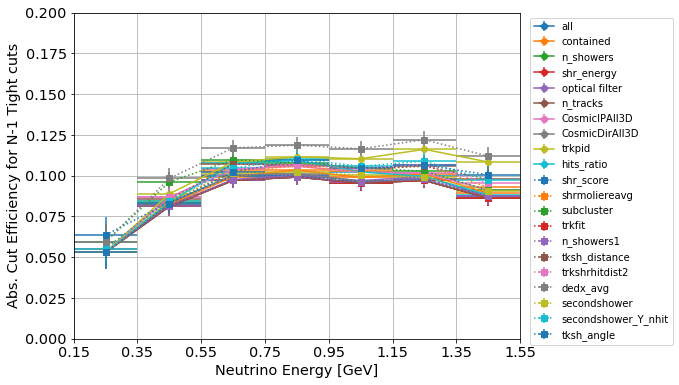

In [64]:
fig, ax = plt.subplots(figsize=(8,6))

bin_edges = np.linspace(0.15,1.55,8)

VAR = 'nu_e' #'_pi0_e'
ACCEPTANCE = 'isVtxInFiducial == 1 and truthFiducial == 1 and npi0==0 and npion==0 and nproton>0'

fullcuts = ''
for c in range(0,len(cutlist)):
    if c==0: fullcuts = cutlist[c]["cut"]
    else: fullcuts = fullcuts+" and "+cutlist[c]["cut"]

print(fullcuts)

alleffs = []

for c in range(0,len(cutlist)):
    if c==0: cut = fullcuts
    else: cut = fullcuts.replace(" and "+cutlist[c]["cut"],"")
    fmt = 'o-'
    if c>9: fmt = 's:'
    centers,vals,errs = Eff(nue,VAR,cut,ACCEPTANCE,bin_edges)
    if c==0: label = "all"
    else: label = cutlist[c]["name"]
    ax.errorbar(centers,vals,yerr=errs,xerr=(bin_edges[1]-bin_edges[0])/2,fmt=fmt,label=label)
    alleffs.append(vals)
ax.set_xlabel('Neutrino Energy [GeV]')
ax.set_ylabel('Abs. Cut Efficiency for N-1 Tight cuts')
ax.set_xticks(bin_edges)
ax.set_ylim(0.,0.2)
ax.set_xlim(bin_edges[0],bin_edges[-1])
plt.legend(bbox_to_anchor=(1.01,1.), loc='upper left', ncol=1)
#plt.title("dr(shr vtx reco, vtx mc sce)<1.0")
plt.grid(True)
plt.show()


[0.15 0.35 0.55 0.75 0.95 1.15 1.35 1.55]


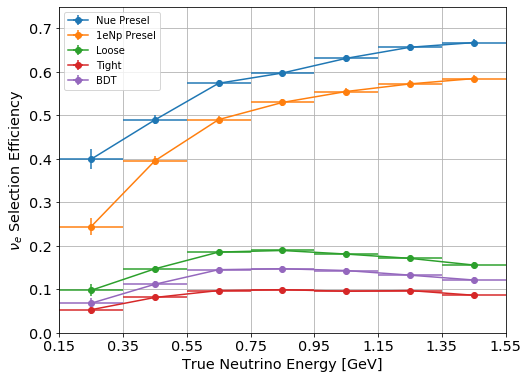

In [76]:
fig, ax = plt.subplots(figsize=(8,6))

bin_edges = np.linspace(0.15,1.55,8)
print(bin_edges)

VAR = 'nu_e' #'_pi0_e'
ACCEPTANCE = 'isVtxInFiducial == 1 and truthFiducial == 1 and npi0==0 and npion==0 and nproton>0'

lables = ['Nue Presel','1eNp Presel','Loose','Tight','BDT']
for i,q in enumerate([PRESQ,NPPRESQ,NPLCUTQ,NPTCUTQ,NPBDTCQ]):
#lables = ['New Tight Selection','Old Tight Selection']
#for i,q in enumerate([NPTCUTQ,OTCUTQ]):
    fmt = 'o-'
    centers,vals,errs = Eff(nue,VAR,q,ACCEPTANCE,bin_edges)
    ax.errorbar(centers,vals,yerr=errs,xerr=(bin_edges[1]-bin_edges[2])/2,fmt=fmt,label=lables[i])
ax.set_xlabel('True Neutrino Energy [GeV]')
ax.set_ylabel(r'$\nu_e$ Selection Efficiency')
ax.set_xticks(bin_edges)
ax.set_ylim(0.,0.75)
#ax.set_ylim(0.,0.15)
ax.set_xlim(bin_edges[0],bin_edges[-1])
plt.legend()
#plt.title("dr(shr vtx reco, vtx mc sce)<1.0")
plt.grid(True)
#plt.yscale('log')
plt.show()
fig.savefig(ls.plots_path+"eff_1eNp_cut_bdt.pdf")

/Users/cerati/Notebooks/PELEE/plotter.py:229: RuntimeWarning: invalid value encountered in double_scalars
  for i, k in enumerate(num)


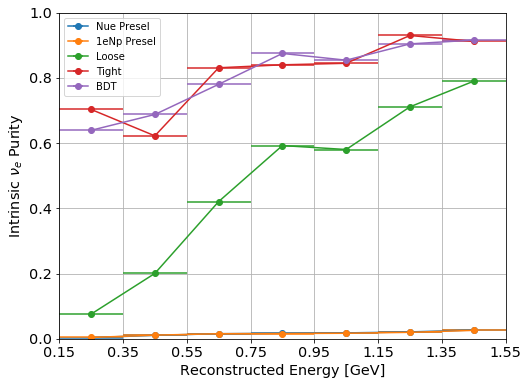

In [77]:
fig, ax = plt.subplots(figsize=(8,6))

bin_edges = np.linspace(0.15,1.55,8)
bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])

lables = ['Nue Presel','1eNp Presel','Loose','Tight','BDT']
for i,q in enumerate([PRESQ,NPPRESQ,NPLCUTQ,NPTCUTQ,NPBDTCQ]):
    fmt = 'o-'
    vals = Pur(my_plotter,'reco_e',q,len(bin_centers),(bin_edges[0],bin_edges[-1]))
    ax.errorbar(bin_centers,vals,xerr=(bin_edges[1]-bin_edges[2])/2,fmt=fmt,label=lables[i])
ax.set_xlabel('Reconstructed Energy [GeV]')
ax.set_ylabel(r'Intrinsic $\nu_e$ Purity')
ax.set_xticks(bin_edges)
ax.set_ylim(0.,1.)
ax.set_xlim(bin_edges[0],bin_edges[-1])
ax.legend()
#plt.title("dr(shr vtx reco, vtx mc sce)<1.0")
ax.grid(True)
plt.show()
fig.savefig(ls.plots_path+"pur_1eNp_cut_bdt.pdf")

/Users/cerati/Notebooks/PELEE/plotter.py:229: RuntimeWarning: invalid value encountered in double_scalars
  for i, k in enumerate(num)


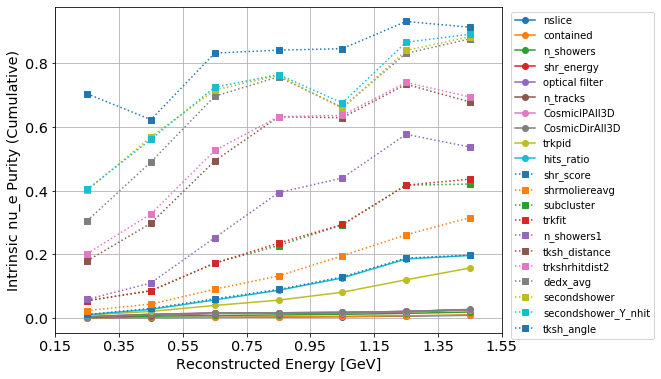

In [78]:
fig, ax = plt.subplots(figsize=(8,6))

bin_edges = np.linspace(0.15,1.55,8)
bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])

for c in range(0,len(cutlist)):
    if c==0: cut = cutlist[c]["cut"]
    else: cut = cut+" and "+cutlist[c]["cut"]
    fmt = 'o-'
    if c>9: fmt = 's:'
    vals = Pur(my_plotter,'reco_e',cut,len(bin_centers),(bin_edges[0],bin_edges[-1]))
    ax.errorbar(bin_centers,vals,fmt=fmt,label=cutlist[c]["name"])
ax.set_xlabel('Reconstructed Energy [GeV]')
ax.set_ylabel('Intrinsic nu_e Purity (Cumulative)')
ax.set_xticks(bin_edges)
ax.set_xlim(bin_edges[0],bin_edges[-1])
ax.legend(bbox_to_anchor=(1.01,1.), loc='upper left', ncol=1)
#plt.title("dr(shr vtx reco, vtx mc sce)<1.0")
ax.grid(True)
plt.show()


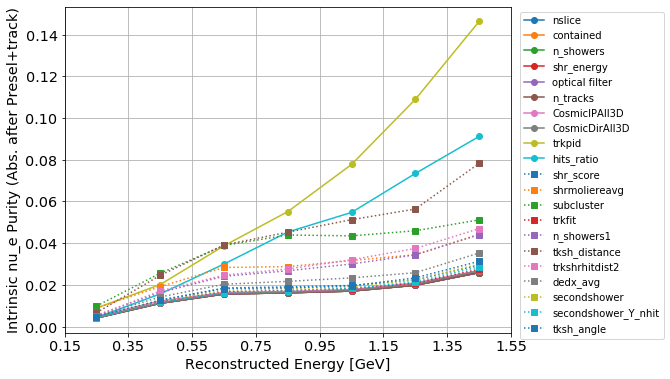

In [79]:
fig, ax = plt.subplots(figsize=(8,6))

bin_edges = np.linspace(0.15,1.55,8)
bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])

PRECUT = PRESQ+" and n_tracks_contained>0"

for c in range(0,len(cutlist)):
    cut = PRECUT+" and "+cutlist[c]["cut"]
    fmt = 'o-'
    if c>9: fmt = 's:'
    vals = Pur(my_plotter,'reco_e',cut,len(bin_centers),(bin_edges[0],bin_edges[-1]))
    ax.errorbar(bin_centers,vals,fmt=fmt,label=cutlist[c]["name"])
ax.set_xlabel('Reconstructed Energy [GeV]')
ax.set_ylabel('Intrinsic nu_e Purity (Abs. after Presel+track)')
ax.set_xticks(bin_edges)
ax.set_xlim(bin_edges[0],bin_edges[-1])
ax.legend(bbox_to_anchor=(1.01,1.), loc='upper left', ncol=1)
#plt.title("dr(shr vtx reco, vtx mc sce)<1.0")
ax.grid(True)
plt.show()


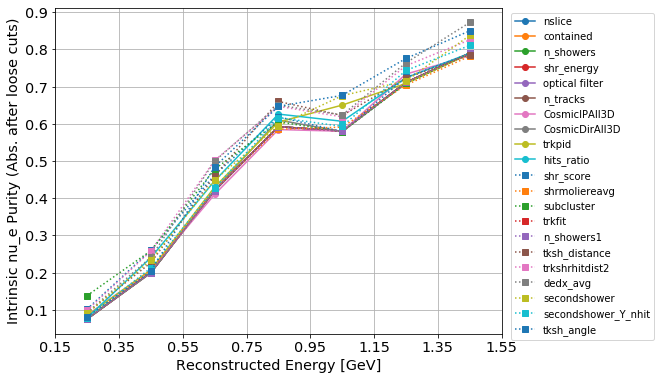

In [80]:
fig, ax = plt.subplots(figsize=(8,6))

bin_edges = np.linspace(0.15,1.55,8)
bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])

for c in range(0,len(cutlist)):
    cut = NPLCUTQ+" and "+cutlist[c]["cut"]
    fmt = 'o-'
    if c>9: fmt = 's:'
    vals = Pur(my_plotter,'reco_e',cut,len(bin_centers),(bin_edges[0],bin_edges[-1]))
    ax.errorbar(bin_centers,vals,fmt=fmt,label=cutlist[c]["name"])
ax.set_xlabel('Reconstructed Energy [GeV]')
ax.set_ylabel('Intrinsic nu_e Purity (Abs. after loose cuts)')
ax.set_xticks(bin_edges)
ax.set_xlim(bin_edges[0],bin_edges[-1])
ax.legend(bbox_to_anchor=(1.01,1.), loc='upper left', ncol=1)
#plt.title("dr(shr vtx reco, vtx mc sce)<1.0")
ax.grid(True)
plt.show()


nslice == 1 and contained_fraction >= 0.9 and n_showers_contained > 0 and shr_energy_tot_cali > 0.07 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and n_tracks_contained > 0 and CosmicIPAll3D > 30. and CosmicDirAll3D > -0.98 and CosmicDirAll3D < 0.98 and trkpid < 0.02 and hits_ratio > 0.65 and shr_score < 0.25 and shrmoliereavg > 2 and shrmoliereavg < 10 and subcluster > 7 and trkfit < 0.70 and n_showers_contained == 1 and tksh_distance < 4.0 and trkshrhitdist2 < 1.5 and (shr_tkfit_nhits_tot > 1 and shr_tkfit_dedx_max > 1.0 and shr_tkfit_dedx_max < 3.8) and (secondshower_Y_nhit<=8 or secondshower_Y_dot<=0.8 or anglediff_Y<=40 or secondshower_Y_vtxdist>=100) and (secondshower_Y_nhit<30) and tksh_angle > -0.9 and tksh_angle < 0.70


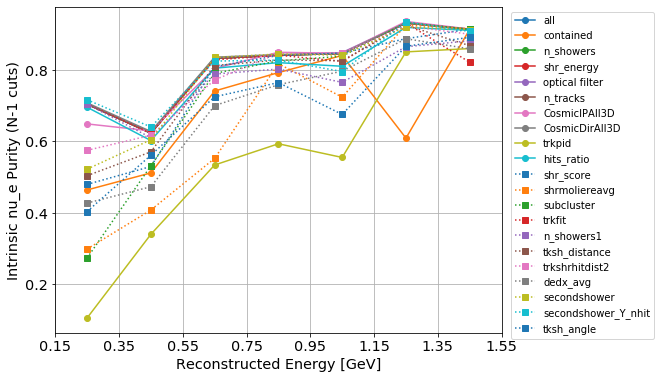

In [81]:
fig, ax = plt.subplots(figsize=(8,6))

bin_edges = np.linspace(0.15,1.55,8)
bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])

fullcuts = ''
for c in range(0,len(cutlist)):
    if c==0: fullcuts = cutlist[c]["cut"]
    else: fullcuts = fullcuts+" and "+cutlist[c]["cut"]

print(fullcuts)

allpurs = []

for c in range(0,len(cutlist)):
    if c==0: cut = fullcuts
    else: cut = fullcuts.replace(" and "+cutlist[c]["cut"],"")
    fmt = 'o-'
    if c>9: fmt = 's:'
    vals = Pur(my_plotter,'reco_e',cut,len(bin_centers),(bin_edges[0],bin_edges[-1]))
    label = cutlist[c]["name"]
    if c==0: label = "all"
    ax.errorbar(bin_centers,vals,fmt=fmt,label=label)
    allpurs.append(vals)
ax.set_xlabel('Reconstructed Energy [GeV]')
ax.set_ylabel('Intrinsic nu_e Purity (N-1 cuts)')
ax.set_xticks(bin_edges)
ax.set_xlim(bin_edges[0],bin_edges[-1])
ax.legend(bbox_to_anchor=(1.01,1.), loc='upper left', ncol=1)
#plt.title("dr(shr vtx reco, vtx mc sce)<1.0")
ax.grid(True)
plt.show()

In [82]:
allpursratio = []
for c in range(0,len(allpurs)): allpursratio.append(allpurs[c]/allpurs[0])
    
alleffsratio = []
for c in range(0,len(alleffs)): alleffsratio.append(alleffs[0]/alleffs[c])


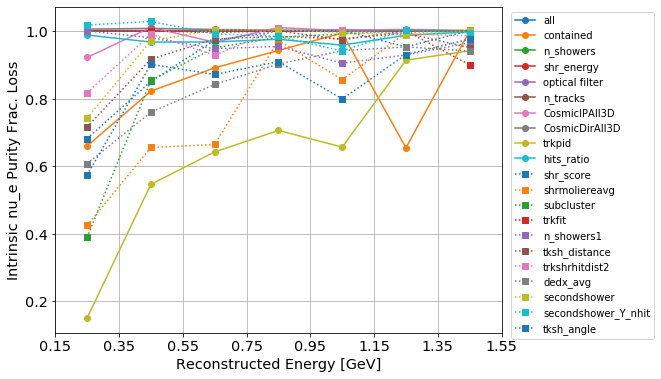

In [83]:
fig, ax = plt.subplots(figsize=(8,6))

for c in range(0,len(cutlist)):
    #if c!=13: continue
    fmt = 'o-'
    if c>9: fmt = 's:'
    label = cutlist[c]["name"]
    if c==0: label = "all"
    ax.errorbar(bin_centers,allpursratio[c],fmt=fmt,label=label)
ax.set_xlabel('Reconstructed Energy [GeV]')
ax.set_ylabel('Intrinsic nu_e Purity Frac. Loss')
ax.set_xticks(bin_edges)
ax.set_xlim(bin_edges[0],bin_edges[-1])
ax.legend(bbox_to_anchor=(1.01,1.), loc='upper left', ncol=1)
#plt.title("dr(shr vtx reco, vtx mc sce)<1.0")
ax.grid(True)
plt.show()



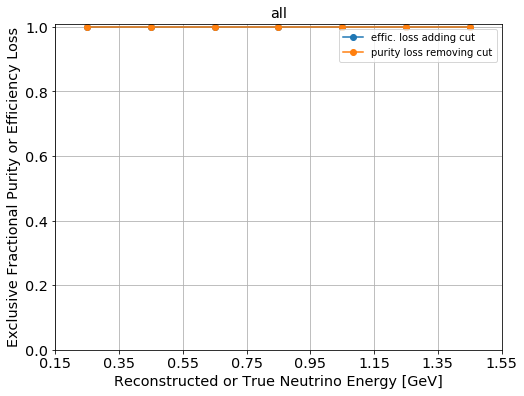

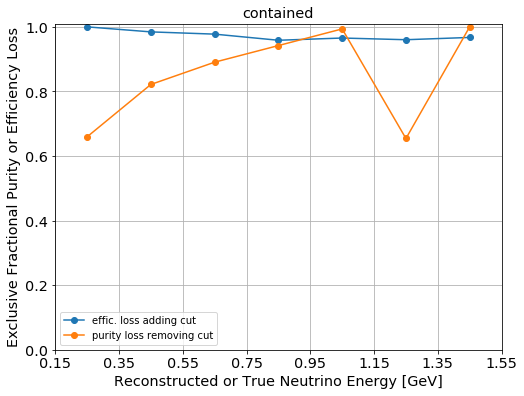

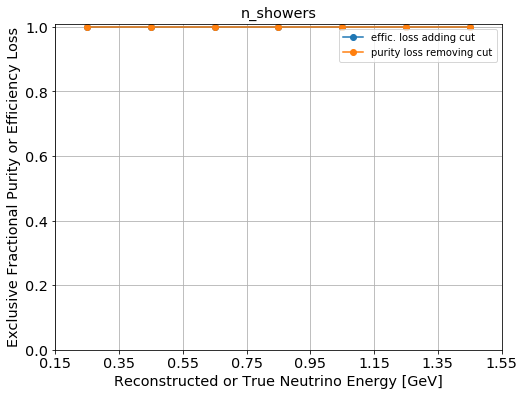

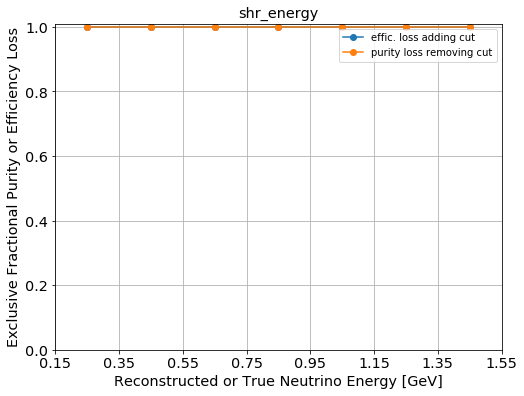

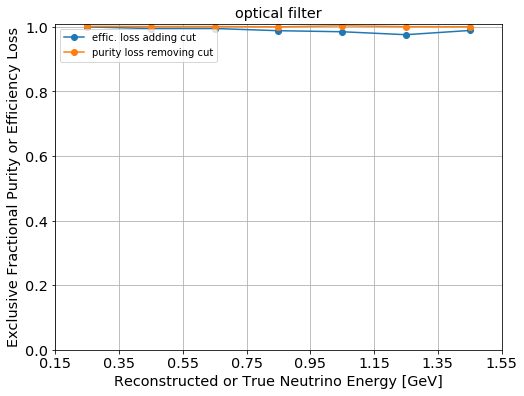

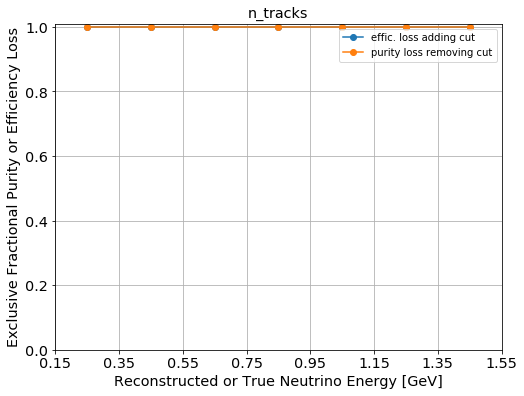

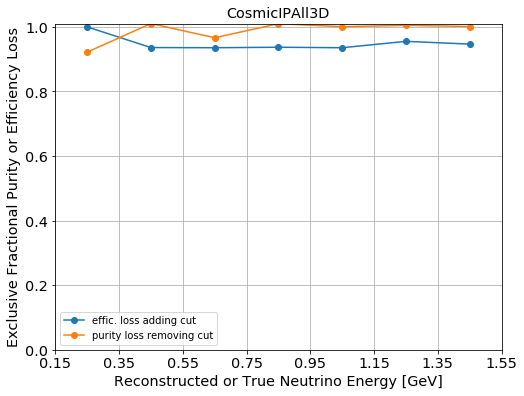

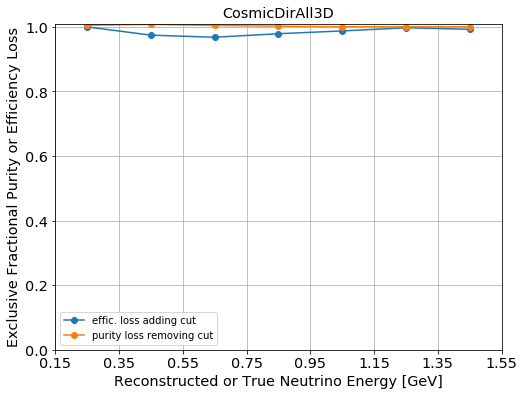

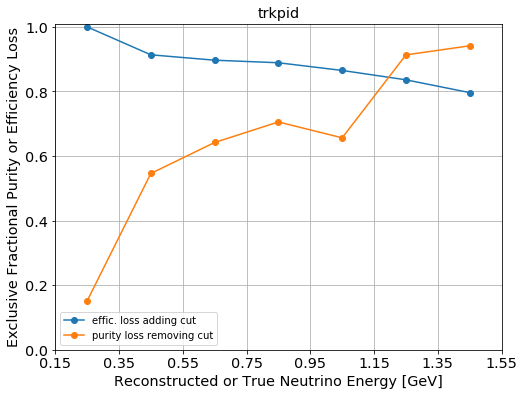

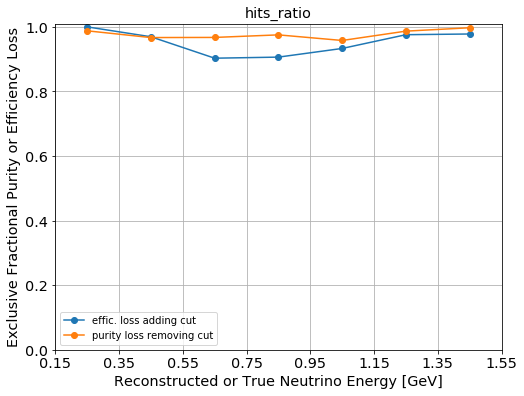

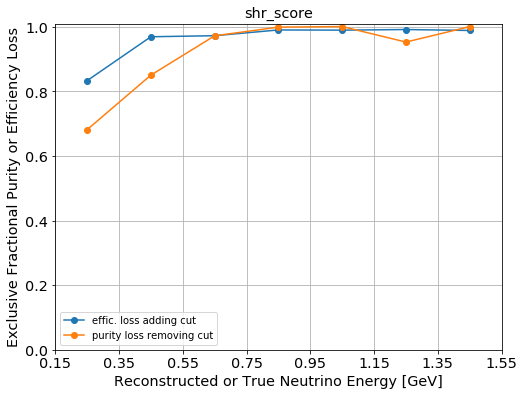

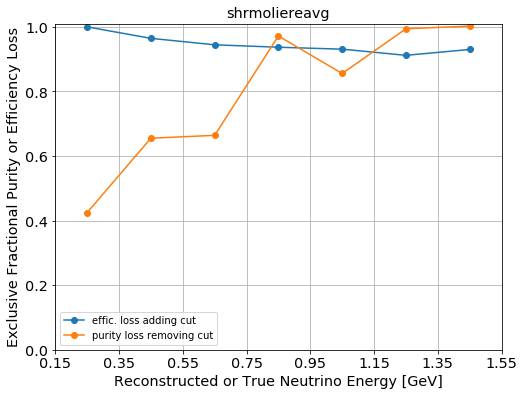

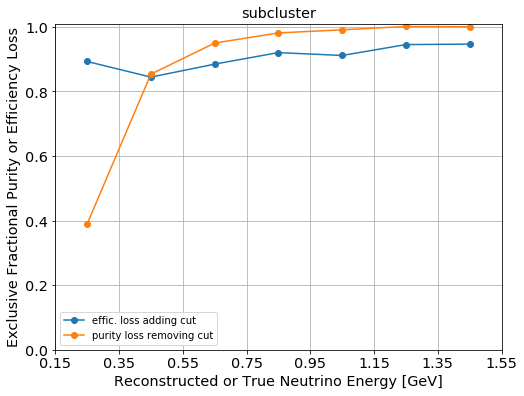

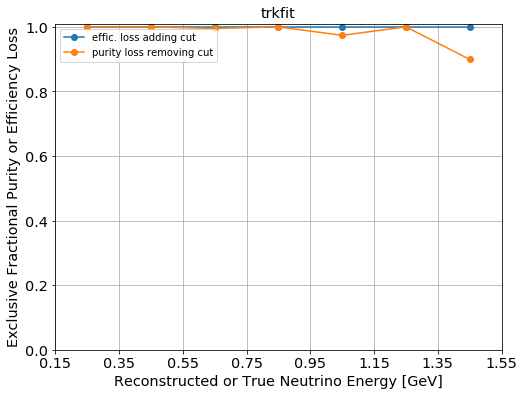

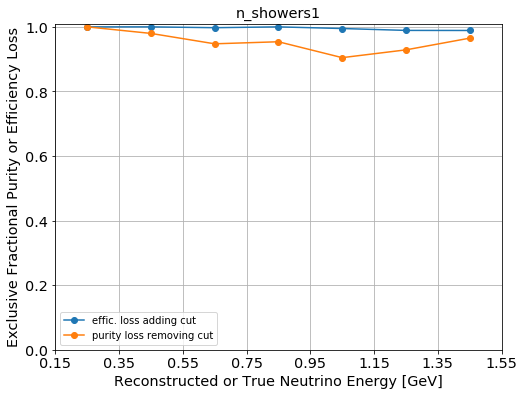

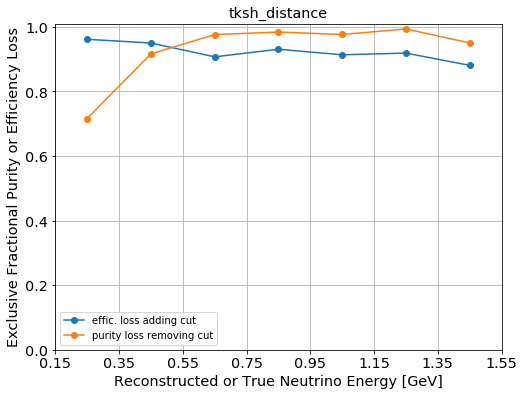

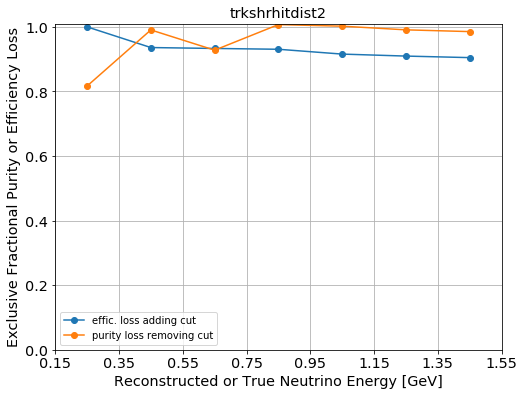

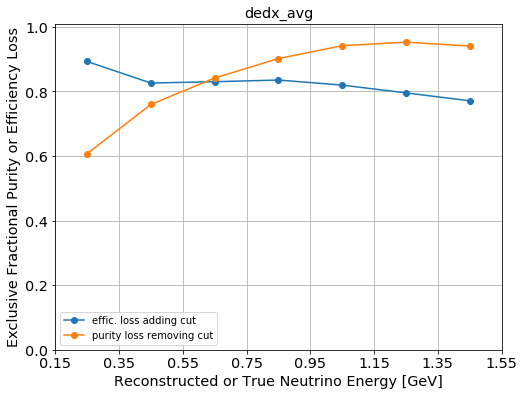

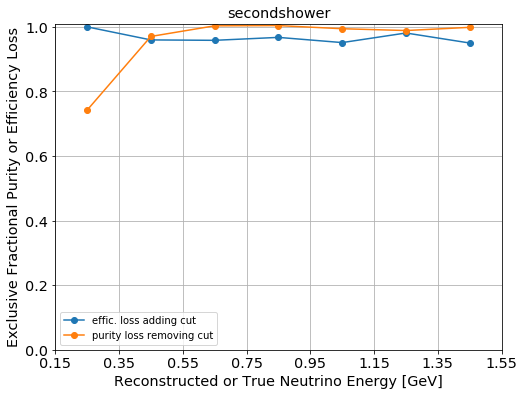

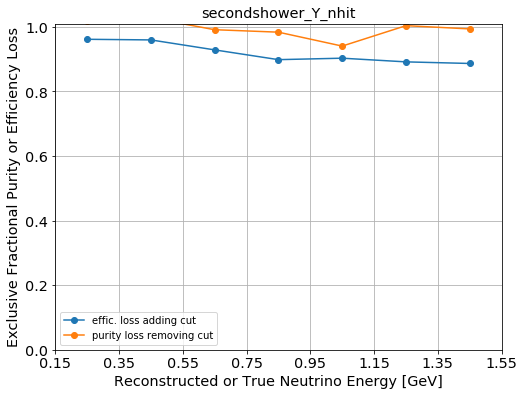

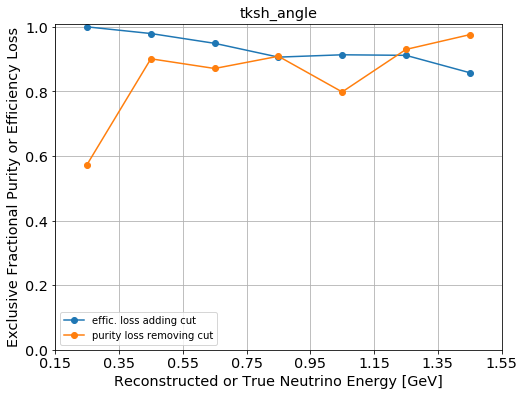

In [84]:
for c in range(0,len(cutlist)):
    fig, ax = plt.subplots(figsize=(8,6))
    label = cutlist[c]["name"]
    if c==0: label = "all"
    ax.errorbar(bin_centers,alleffsratio[c],fmt='o-',label="effic. loss adding cut")
    ax.errorbar(bin_centers,allpursratio[c],fmt='o-',label="purity loss removing cut")
    ax.set_xlabel('Reconstructed or True Neutrino Energy [GeV]')
    ax.set_ylabel('Exclusive Fractional Purity or Efficiency Loss')
    ax.legend()
    #ax.legend(bbox_to_anchor=(1.01,1.), loc='upper left', ncol=1)
    ax.set_xticks(bin_edges)
    ax.set_xlim(bin_edges[0],bin_edges[-1])
    ax.set_ylim(0.,1.01)
    ax.set_title(label)
    ax.grid(True)
    plt.show()
